In [2]:
pip install cryptocompare

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for cryptocompare: filename=cryptocompare-0.7.6-py3-none-any.whl size=6315 sha256=452758dfa2c5f3c80774099a6f6b797089ea43a32bc5dd4ebc390d78a3569fb3
  Stored in directory: c:\users\xie\appdata\local\pip\cache\wheels\0e\94\d6\f0f5fc4ff1b5c903ec73af2a2e9ce6d72df9d541c3b1b9db77
Successfully built cryptocompare
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandas_ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218925 sha256=acc0f27c634a38abcf542ad835f541a4613cf9e638e3eed36bee13a1f14c3dab
  Stored in directory: c:\users\xie\appdata\local\pip\cache\wheels\fd\ed\18\2a12fd1b7906c63efca6accb351929f2c7f6bbc674e1c0ba5d
Successfully built pandas_ta
Note: you may need to restart the kernel to use updated packages.


In [62]:
import cryptocompare
import pandas as pd
import pandas_ta as ta
import numpy as np
import time
import matplotlib.pyplot as plt

def get_cryptocompare_data(symbol, start_date, end_date):
    start_ts = int(time.mktime(time.strptime(start_date, "%Y-%m-%d")))
    end_ts = int(time.mktime(time.strptime(end_date, "%Y-%m-%d")))
    data = cryptocompare.get_historical_price_day(symbol, currency='USD', toTs=end_ts, limit=2000)
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('timestamp', inplace=True)
    return df[['high', 'low', 'close', 'open', 'volumefrom']]

In [64]:
def calculate_indicators(df):
    df['OBV'] = ta.obv(df['close'], df['volumefrom'])
    df['AD'] = ta.ad(df['high'], df['low'], df['close'], df['volumefrom'])
    df['ADOSC'] = ta.adosc(df['high'], df['low'], df['close'], df['volumefrom'], fast=3, slow=10)
    df['MFI'] = ta.mfi(df['high'], df['low'], df['close'], df['volumefrom'], length=14)
    df['BOP'] = ta.bop(df['open'], df['high'], df['low'], df['close'])
    return df

In [66]:
def generate_signals(df):
    signal_names = ['OBV', 'AD', 'ADOSC', 'MFI', 'BOP']
    for name in signal_names:
        df[f'Signal_{name}'] = 0

    for i in range(3, len(df), 3):
        # OBV signal
        if df['OBV'][i] > df['OBV'][i-3] and df['MFI'][i] < 40:
            df.at[df.index[i], 'Signal_OBV'] = 1
        elif df['OBV'][i] < df['OBV'][i-3] and df['MFI'][i] > 60:
            df.at[df.index[i], 'Signal_OBV'] = -1

        # AD signal
        if df['AD'][i] > df['AD'][i-3] and df['MFI'][i] < 40:
            df.at[df.index[i], 'Signal_AD'] = 1
        elif df['AD'][i] < df['AD'][i-3] and df['MFI'][i] > 60:
            df.at[df.index[i], 'Signal_AD'] = -1

        # ADOSC signal
        if df['ADOSC'][i] > 0 and df['MFI'][i] < 40:
            df.at[df.index[i], 'Signal_ADOSC'] = 1
        elif df['ADOSC'][i] < 0 and df['MFI'][i] > 60:
            df.at[df.index[i], 'Signal_ADOSC'] = -1

        # MFI signal
        if df['MFI'][i] < 40:
            df.at[df.index[i], 'Signal_MFI'] = 1
        elif df['MFI'][i] > 60:
            df.at[df.index[i], 'Signal_MFI'] = -1

        # BOP signal
        if df['BOP'][i] > 0 and df['MFI'][i] < 40:
            df.at[df.index[i], 'Signal_BOP'] = 1
        elif df['BOP'][i] < 0 and df['MFI'][i] > 60:
            df.at[df.index[i], 'Signal_BOP'] = -1

    return df

In [68]:
def backtest_signals(df, signal_col):
    initial_cash = 10000
    position = 0
    cash = initial_cash

    print(f"\n--- Backtesting {signal_col} ---")
    for i in range(1, len(df)):
        signal = df[signal_col][i]
        price = df['close'][i]

        if signal == 1 and position == 0:
            position = cash / price
            cash = 0
            print(f"买入：日期: {df.index[i]}, 价格: {price:.2f}")
        elif signal == -1 and position > 0:
            cash = position * price
            position = 0
            print(f"卖出：日期: {df.index[i]}, 价格: {price:.2f}")

    final_balance = cash + (position * df['close'].iloc[-1])
    print(f"{signal_col} 最终资金余额: {final_balance:.2f}")
    return final_balance

In [70]:
def plot_signals(df, symbol):
    plt.figure(figsize=(15, 12))

    plt.subplot(6, 1, 1)
    plt.plot(df['close'], label='Close', color='black')
    plt.title(f'{symbol} Close Price')
    plt.legend()

    plt.subplot(6, 1, 2)
    plt.plot(df['OBV'], label='OBV', color='blue')
    plt.title('OBV')
    plt.legend()

    plt.subplot(6, 1, 3)
    plt.plot(df['AD'], label='AD', color='green')
    plt.title('Accumulation/Distribution Line')
    plt.legend()

    plt.subplot(6, 1, 4)
    plt.plot(df['ADOSC'], label='ADOSC', color='red')
    plt.title('Chaikin AD Oscillator')
    plt.legend()

    plt.subplot(6, 1, 5)
    plt.plot(df['MFI'], label='MFI', color='cyan')
    plt.title('Money Flow Index')
    plt.legend()

    plt.subplot(6, 1, 6)
    plt.plot(df['BOP'], label='BOP', color='magenta')
    plt.title('Balance of Power')
    plt.legend()

    plt.tight_layout()
    plt.show()

C:\Users\XIE\AppData\Local\Temp\ipykernel_4420\3307571011.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.50023960e+08 9.82994840e+08 1.04859019e+09 ... 3.97833511e+09
 2.15406433e+09 3.64895355e+09]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['MFI'] = ta.mfi(df['high'], df['low'], df['close'], df['volumefrom'], length=14)
C:\Users\XIE\AppData\Local\Temp\ipykernel_4420\3307571011.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.71335510e+08 8.08155139e+08 1.12841550e+09 9.68725893e+08
 4.06189637e+08 5.23854802e+08 5.27596471e+08 5.33426994e+08
 3.13275172e+08 5.12974242e+08 2.66703543e+08 4.69960640e+08
 2.93825741e+08 2.29954083e+08 4.82292309e+08 7.20657984e+08
 8.51621790e+08 5.89926637e+08 3.81484552e+08 2.85290362e+08
 2.60315471e+08 2.70074738e+08 4.84986


--- Backtesting Signal_OBV ---
买入：日期: 2019-09-21 00:00:00, 价格: 9988.38
卖出：日期: 2020-01-10 00:00:00, 价格: 8190.31
买入：日期: 2020-03-04 00:00:00, 价格: 8773.78
卖出：日期: 2020-03-28 00:00:00, 价格: 6252.49
买入：日期: 2020-06-29 00:00:00, 价格: 9187.07
卖出：日期: 2020-08-04 00:00:00, 价格: 11194.18
买入：日期: 2020-09-15 00:00:00, 价格: 10786.70
卖出：日期: 2020-09-18 00:00:00, 价格: 10937.89
买入：日期: 2020-12-14 00:00:00, 价格: 19274.69
卖出：日期: 2020-12-23 00:00:00, 价格: 23239.50
买入：日期: 2021-01-28 00:00:00, 价格: 33443.87
卖出：日期: 2021-02-12 00:00:00, 价格: 47435.54
买入：日期: 2021-03-05 00:00:00, 价格: 48775.37
卖出：日期: 2021-03-14 00:00:00, 价格: 58998.89
买入：日期: 2021-04-28 00:00:00, 价格: 54877.94
卖出：日期: 2021-05-10 00:00:00, 价格: 55870.01
买入：日期: 2021-05-22 00:00:00, 价格: 37491.50
卖出：日期: 2021-08-02 00:00:00, 价格: 39158.53
买入：日期: 2021-11-21 00:00:00, 价格: 58700.83
卖出：日期: 2021-12-27 00:00:00, 价格: 50714.73
买入：日期: 2022-01-11 00:00:00, 价格: 42743.03
卖出：日期: 2022-02-13 00:00:00, 价格: 42069.84
买入：日期: 2022-02-25 00:00:00, 价格: 39239.77
卖出：日期: 2022-03-21 00:00:00, 价格

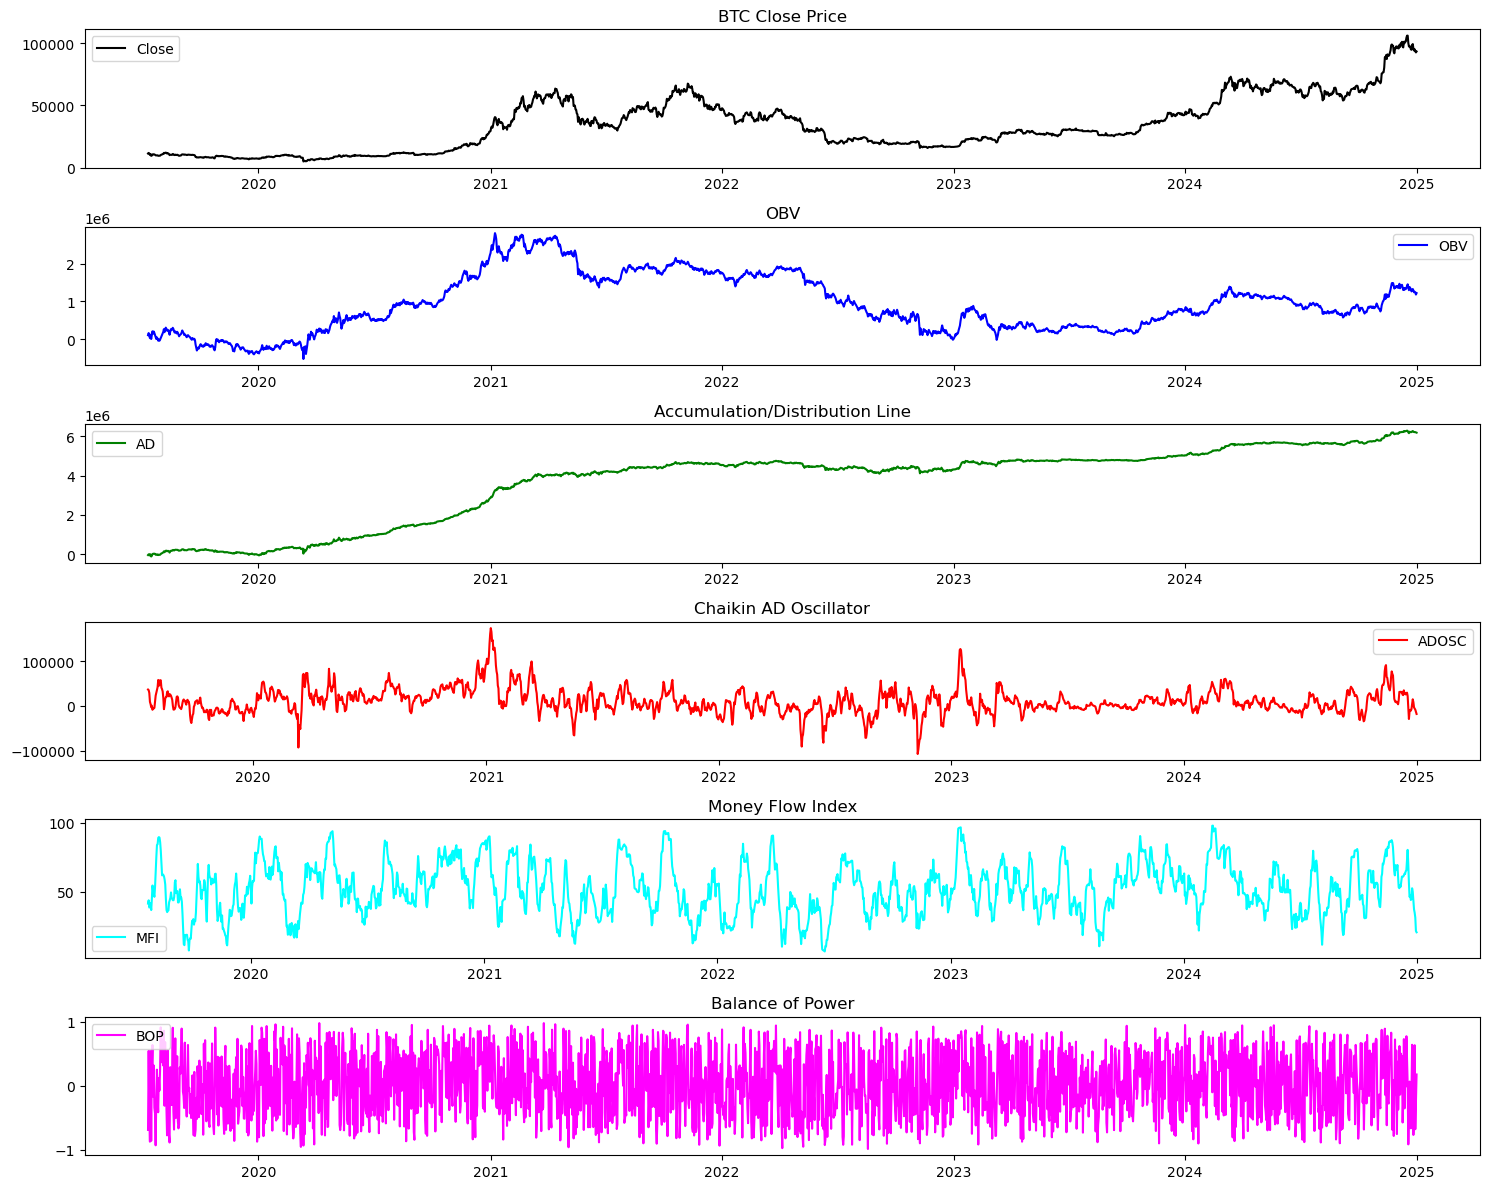

In [72]:
def main():
    symbol = 'BTC'
    start_date = '2019-01-01'
    end_date = '2025-01-01'

    df = get_cryptocompare_data(symbol, start_date, end_date)
    df = calculate_indicators(df)
    df = generate_signals(df)

    results = {}
    for name in ['OBV', 'AD', 'ADOSC', 'MFI', 'BOP']:
        signal_col = f'Signal_{name}'
        balance = backtest_signals(df, signal_col)
        results[name] = balance

    print("\n--- Top 3 Performing Indicators ---")
    top3 = sorted(results.items(), key=lambda x: x[1], reverse=True)[:3]
    for i, (name, bal) in enumerate(top3, 1):
        print(f"{i}. {name} - Final Balance: ${bal:.2f}")

    plot_signals(df, symbol)

if __name__ == "__main__":
    main()